# Inventory Monitoring at Distribution Centers
Inventory management is vital to a company’s health because it balances supply with demand by ensuring that product is available at the right time by tracking product up and down the supply chain.  Too much stock costs money and reduces cash flow and too little stock could lead to unfilled customer orders and lost sales.

This project will produce a Convolutional Neural Network (CNN) which is a deep learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects / objects in the image, and be able to differentiate one from the other.  AWS SageMaker will be used to train the CNN model to classify the number of objects in each bin.

In [3]:
# uncomment below to install libraries

# !pip install smdebug
# !pip install altair
# !pip install split-folders

In [4]:
# import libraries
import pandas as pd
import altair as alt
import random
import os
import boto3
from tqdm import tqdm
from PIL import Image
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

## Data Preparation
The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))


Run the cell below to download the data to S3.

In [ ]:
download_and_arrange_data()

## Dataset
The Amazon Bin Image Dataset contains 5 classes. After downloading the dataset, we will review the distribution of each class.

In [7]:
data_contents = []

# loop over each subfolder in train_data folder
for image_class in range(1,6):
    # create temporary dictionary
    contents_dict = {}
    subfolder = f'train_data/{image_class}'
    # count the number of files in each subfolder
    num_files = len(os.listdir(subfolder))
    
    contents_dict['image_class'] = image_class
    contents_dict['number_of_images'] = num_files
    
    # append dictioanry to list
    data_contents.append(contents_dict)

In [8]:
df_data = pd.DataFrame(data_contents)
df_data['percentage'] = round(df_data['number_of_images'] / df_data['number_of_images'].sum(), 2)
df_data

image_class  number_of_images  percentage
0            1              1228        0.12
1            2              2299        0.22
2            3              2666        0.26
3            4              2373        0.23
4            5              1875        0.18

In [9]:
print('Total number of images in dataset are', df_data['number_of_images'].sum())

Total number of images in dataset are 10441


In [10]:
bars = alt.Chart(df_data).mark_bar(size=50).encode(
    x=alt.X('image_class:O', title='Image Class'),
    y=alt.Y('number_of_images:Q', title='Number of Images', axis=alt.Axis(domain=False))
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    dx=3,
).encode(
    text='number_of_images:Q'
)

(bars+text).properties(
    width=400,
    title={
        'text': ['Distribution of images per class'],
        'subtitle': ['Total number of images in dataset are 10,441','\n']
    }
).configure_title(fontSize=18, anchor='start')

alt.LayerChart(...)

### Review sample images from dataset
Let's create a function that takes a subfolder and returns a random image.

Sample image returned for image class 1


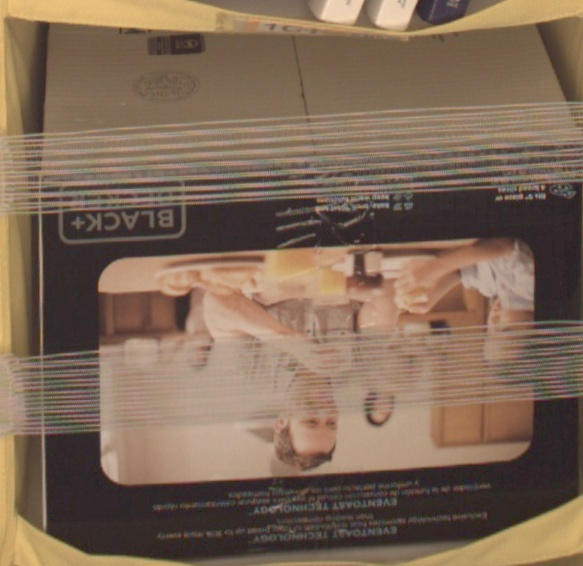

In [11]:
# create a function that 
def get_random_image(subfolder):
    image = random.choice(os.listdir(f'train_data/{subfolder}'))
    image_path = os.path.join('train_data', f'{subfolder}', image)
    
    print(f'Sample image returned for image class {subfolder}')
    return Image.open(image_path)


get_random_image(1)

Sample image returned for image class 2


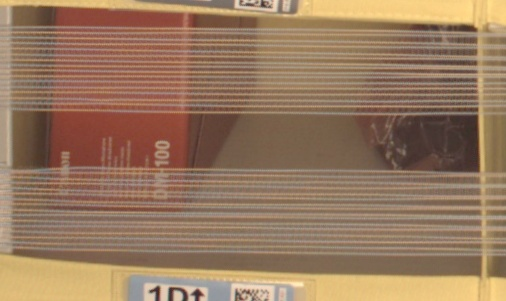

In [12]:
get_random_image(2)

Sample image returned for image class 3


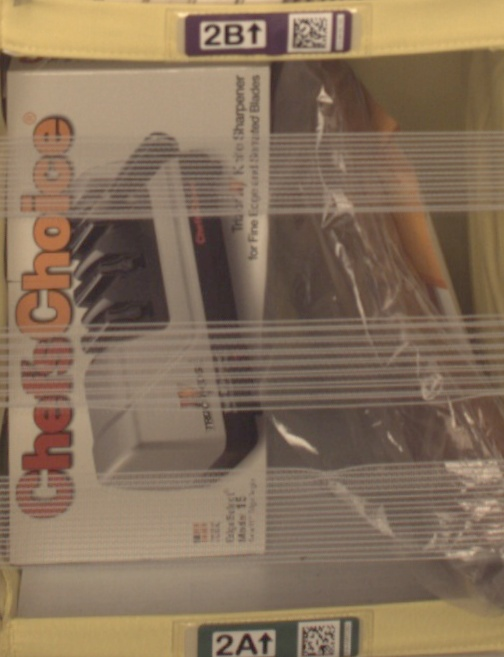

In [13]:
get_random_image(3)

Sample image returned for image class 4


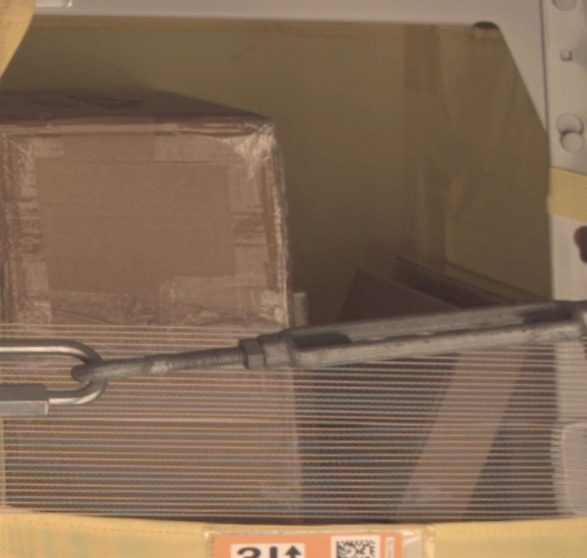

In [14]:
get_random_image(4)

Sample image returned for image class 5


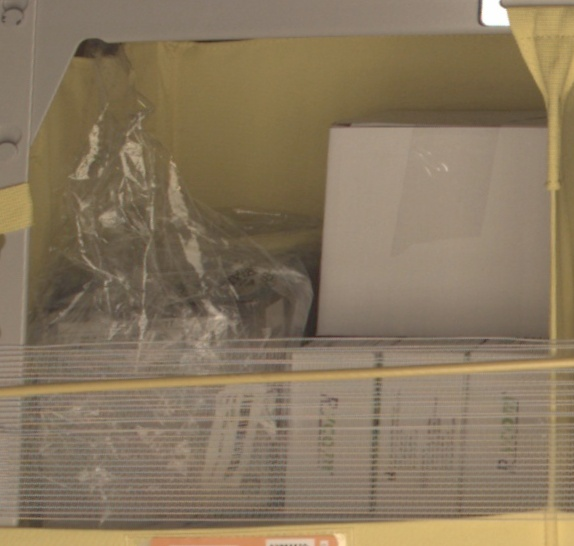

In [15]:
get_random_image(5)

### Split data into train, validation, and test sets
The split-folders Python module is a nice package that allows us to take a folder that has subfolders and split the files into train, validation, and test folders.  If you have tqdm installed then a progress bar will be displayed when moving files.

In [ ]:
import splitfolders
# folder containing training data that needs to be split into separate train, validation, test folders
input_folder = 'train_data'
# name of folder that will contain train, validation, test folders
output_folder = 'data'

splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.8, 0.1, 0.1))

In [16]:
data_contents = []

# loop over each subfolder in data folder

for parent_folder in os.listdir('data'):
    parent_folder_path = os.listdir(os.path.join('data', parent_folder))
    
    # create temporary dictionary
    
    
    for subfolder in parent_folder_path:
        full_path = os.path.join('data', parent_folder, subfolder)
        # print(full_path)
        
        contents_dict = {}
        # count the number of files in each subfolder
        num_files = len(os.listdir(full_path))

        contents_dict['split'] = parent_folder
        contents_dict['image_class'] = subfolder
        contents_dict['number_of_images'] = num_files

        # append dictioanry to list
        data_contents.append(contents_dict)

In [17]:
df_data = pd.DataFrame(data_contents)
df_data

split image_class  number_of_images
0    test           4               238
1    test           2               231
2    test           1               124
3    test           5               188
4    test           3               268
5   train           4              1898
6   train           2              1839
7   train           1               982
8   train           5              1500
9   train           3              2132
10    val           4               237
11    val           2               229
12    val           1               122
13    val           5               187
14    val           3               266

In [18]:
df_data.groupby('split')['number_of_images'].sum()

split
test     1049
train    8351
val      1041
Name: number_of_images, dtype: int64

In [19]:
bars = alt.Chart(df_data).mark_bar().encode(
    x=alt.X('split:N', title='Image Class'),
    y=alt.Y('number_of_images:Q', title='Number of Images', axis=alt.Axis(domain=False)),
    color=alt.Color('split'),
    column=alt.Column('image_class:O', title=None)
).properties(
    width=80,
    title={
    'text': ['Distribution of images per class'],
    'subtitle': ['Train set images: 8351','Validation set images: 1041', 'Test set images: 1049', '\n']
    }
).configure_title(fontSize=18, anchor='start')

bars

alt.Chart(...)

### Upload train, validation, and test sets to S3

In [ ]:
# upload data folder to s3 bucket and use --quiet to suppress progress messages

!aws s3 cp data s3://amazon-bin-images/ --recursive --quiet

Let's confirm that the data was upload to S3.

In [ ]:
! aws s3 ls s3://amazon-bin-images/

## Model Training
### Hyperparameter Tuning
We will search through a hyperparameter space and get the value of the best hyperparameters.

In [24]:
# Initialize the hyperparameters ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(10,20) # train for 10, 15, and  20 epochs
}

role = sagemaker.get_execution_role()

# ensure that the metric definitions match those found in the test function in train.py
# this can be found in line 44 of train.py
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [39]:
# create the training estimator

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_inventory_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

# Create the HyperparameterTuner Object
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

Select training, test, and validation datasets and fit them to the tuner.

In [40]:
bucket = 'amazon-bin-images'

model_inputs = {"train": f"s3://{bucket}/train/",
                "test":f"s3://{bucket}/test/",
                "validate": f"s3://{bucket}/val/"}
model_inputs

{'train': 's3://amazon-bin-images/train/',
 'test': 's3://amazon-bin-images/test/',
 'validate': 's3://amazon-bin-images/val/'}

### Fit the tuner

In [41]:
# Fit the tuner
tuner.fit(model_inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................!


### View the tuning results

In [47]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner._current_job_name) # get name of latest hpo training job

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  epochs        lr                            TrainingJobName  \
3       "32"    12.0  0.058081  pytorch-training-221231-0221-001-d0b07d19   
0       "32"    11.0  0.005295  pytorch-training-221231-0221-004-2d45c96a   
1       "64"    12.0  0.025270  pytorch-training-221231-0221-003-d81977e4   
2       "64"    20.0  0.001467  pytorch-training-221231-0221-002-cfd6ed7a   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
3         Completed             1.580604 2022-12-31 02:23:28+00:00   
0         Completed             1.546589 2022-12-31 02:35:00+00:00   
1         Completed             1.474337 2022-12-31 02:33:56+00:00   
2         Completed             1.448651 2022-12-31 02:23:02+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
3 2022-12-31 02:32:57+00:00                       569.0  
0 2022-12-31 02:39:08+00:00                       248.0  
1 2022-12-31 02:44:10+00:00                       614.0  
2 2022-12-31 02:34:46+00:00                       704.0

### Find the best hyperparameters

In [48]:
# Find the best hyperparameters
print(tuner.describe()['HyperParameterTuningJobName'])

best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()

pytorch-training-221231-0221

2022-12-31 02:34:58 Starting - Preparing the instances for training
2022-12-31 02:34:58 Downloading - Downloading input data
2022-12-31 02:34:58 Training - Training image download completed. Training in progress.
2022-12-31 02:34:58 Uploading - Uploading generated training model
2022-12-31 02:34:58 Completed - Resource reused by training job: pytorch-training-221231-0221-004-2d45c96a


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'epochs': '20',
 'lr': '0.0014671136028592893',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_inventory_hpo-2022-12-31-02-21-34-777"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-468866419413/pytorch_inventory_hpo-2022-12-31-02-21-34-777/source/sourcedir.tar.gz"'}

### Initialize the best hyperparameters

In [49]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "lr": float(best_estimator.hyperparameters()['lr']),
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', ''))}
hyperparameters

{'batch_size': 64, 'lr': 0.0014671136028592893, 'epochs': 20}

## Model Profiling and Debugging
We will use model debugging and profiling to better monitor and debug the model training job.

In [62]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    CollectionConfig,
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)

### Initialize the debugger hook configuration

In [63]:
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(collection_configs=collection_configs )

### Create and fit the estimator and attach the profiler and debugger
An estimator will be created using the optimal hyperparameters found during tuning.

In [64]:
# Create and fit the estimator
estimator = PyTorch(
    entry_point='train_debug_model.py',
    base_job_name='pytorch-inventory-estimator',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [65]:
estimator.fit(model_inputs, wait=True)

2022-12-31 03:07:25 Starting - Starting the training job...
2022-12-31 03:07:54 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-12-31 03:08:55 Downloading - Downloading input data...
2022-12-31 03:09:15 Training - Downloading the training image......
2022-12-31 03:10:15 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-31 03:10:32,421 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-12-31 03:10:32,451 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-31 03:10:32,454 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-31 03:10:32,619 sagemaker-containers INFO     Module default_user_m

From the output above we can see that the testing accuracy was 30% during model training.

### Review latest training job

In [66]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

Training jobname: pytorch-inventory-estimator-2022-12-31-03-07-24-661


In [67]:
pd.DataFrame(estimator.latest_training_job.rule_job_summary())

RuleConfigurationName  \
0         VanishingGradient   
1                   Overfit   
2              Overtraining   
3  PoorWeightInitialization   
4            ProfilerReport   

                                RuleEvaluationJobArn RuleEvaluationStatus  \
0  arn:aws:sagemaker:us-east-1:468866419413:proce...        NoIssuesFound   
1  arn:aws:sagemaker:us-east-1:468866419413:proce...        NoIssuesFound   
2  arn:aws:sagemaker:us-east-1:468866419413:proce...        NoIssuesFound   
3  arn:aws:sagemaker:us-east-1:468866419413:proce...                Error   
4  arn:aws:sagemaker:us-east-1:468866419413:proce...        NoIssuesFound   

                  LastModifiedTime  \
0 2022-12-31 03:18:39.182000+00:00   
1 2022-12-31 03:18:39.182000+00:00   
2 2022-12-31 03:18:39.182000+00:00   
3 2022-12-31 03:18:39.182000+00:00   
4 2022-12-31 03:18:33.180000+00:00   

                                       StatusDetails  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3  InternalServerError: We encountered an interna...  
4                                                NaN

### Review training performance

In [68]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-12-31 03:32:46.994 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/debug-output
[2022-12-31 03:32:47.213 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 5111 more expected)', IncompleteRead(0 bytes read, 5111 more expected)) while reading s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/debug-output/index/000000000/000000000090_worker_0.json . Will retry now
[2022-12-31 03:32:49.653 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-31 03:32:50.693 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 INFO trial.py:210] 

#### Setup functions to log and plot the output tensors

In [69]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

### Cross entropy loss evaluation

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


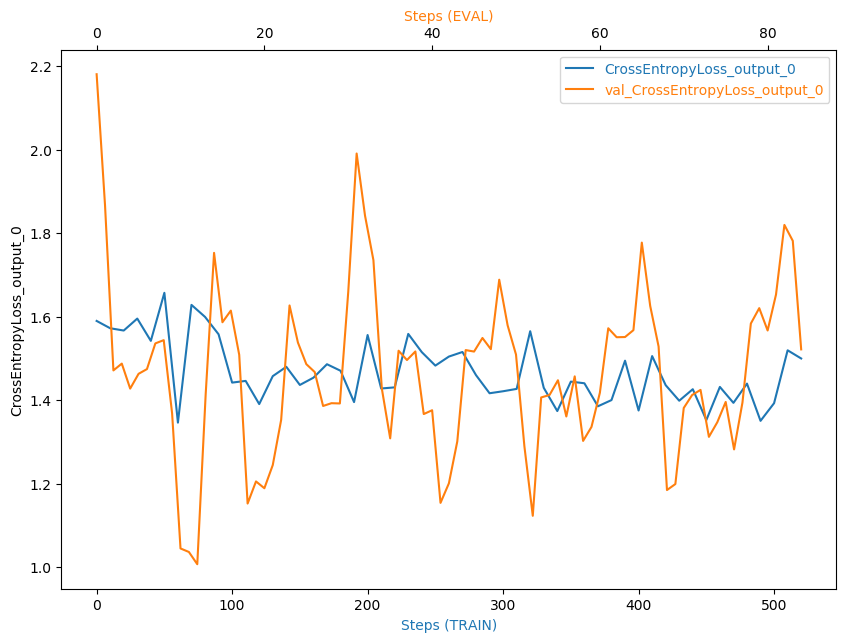

In [71]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

Cross entropy loss for the training phase remains rather stable throughout training.  The validation phase has its cross entropy loss start high, then dive low, and then stabilize somewhat but the range of values are larger than the cross entropy loss for the training phase.

### Profiler Report

In [72]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/rule-output'

Download the profiler report.

In [73]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease

In [74]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

Run the cell below to display the profiler report.

In [166]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying and Querying

In [76]:
# get the location of our model
model_path = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_path}")

Model: s3://sagemaker-us-east-1-468866419413/pytorch-inventory-estimator-2022-12-31-03-07-24-661/output/model.tar.gz


In [77]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

### Create the PyTorch model

In [78]:
pytorch_model = PyTorchModel(model_data=model_path,
                             role=role,
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

### Deploy the endpoint

In [79]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

------!

### Run a prediction on the endpoint

In [157]:
import numpy as np
import io

def predict_image_label(dataset, subfolder):
    image = random.choice(os.listdir(f'data/{dataset}/{subfolder}'))
    image_path = os.path.join(f'data/{dataset}', f'{subfolder}', image)
    
    with open(image_path, 'rb') as f:
        payload = f.read()
    
    # print(f'Sample image selected for image class: {subfolder}')
    # # generate prediction for image
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    
    print(f'Image path: {image_path}')
    print(f'Image label: {subfolder}')
    
    predicted_label = np.argmax(response, 1)[0]
    print(f'Predicted label: {predicted_label}')
    # print(response)
    
    return display(Image.open(io.BytesIO(payload)))

Image path: data/test/1/08945.jpg
Image label: 1
Predicted label: 0


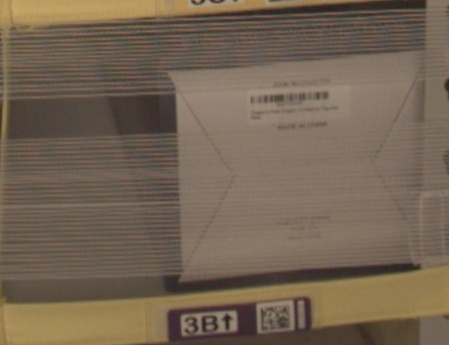

In [158]:
predict_image_label('test', 1)

Image path: data/test/2/01623.jpg
Image label: 2
Predicted label: 0


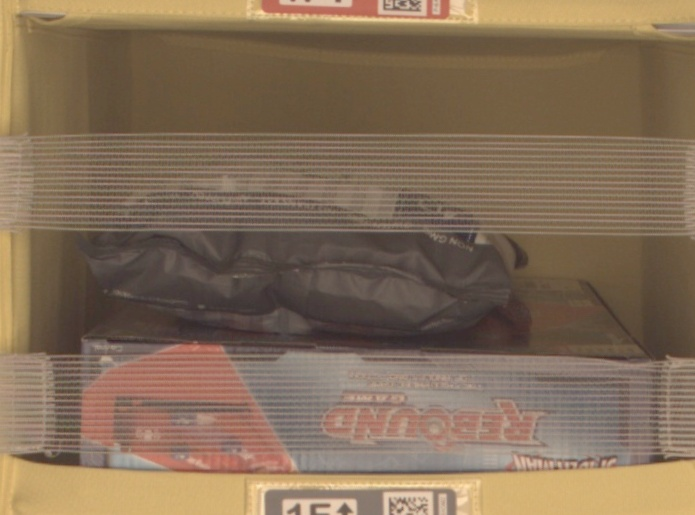

In [161]:
predict_image_label('test', 2)

Image path: data/test/3/01663.jpg
Image label: 3
Predicted label: 2


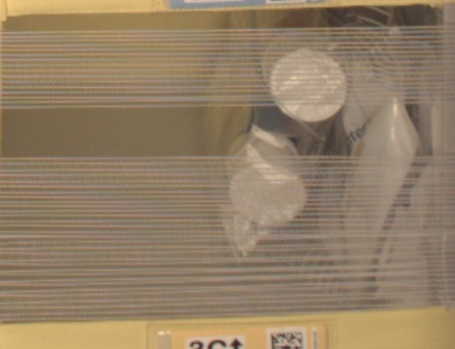

In [165]:
predict_image_label('test', 3)

Image path: data/test/4/100801.jpg
Image label: 4
Predicted label: 2


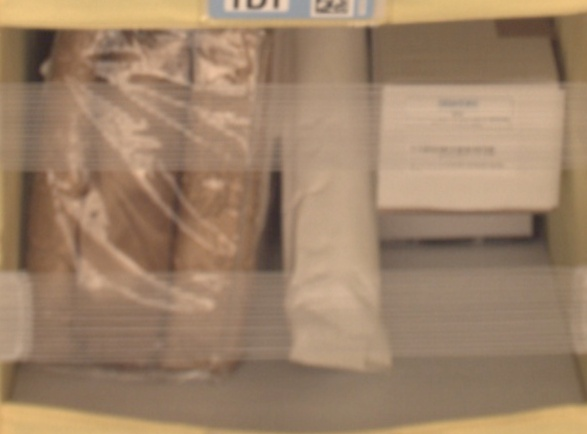

In [163]:
predict_image_label('test', 4)

Image path: data/test/5/100403.jpg
Image label: 5
Predicted label: 2


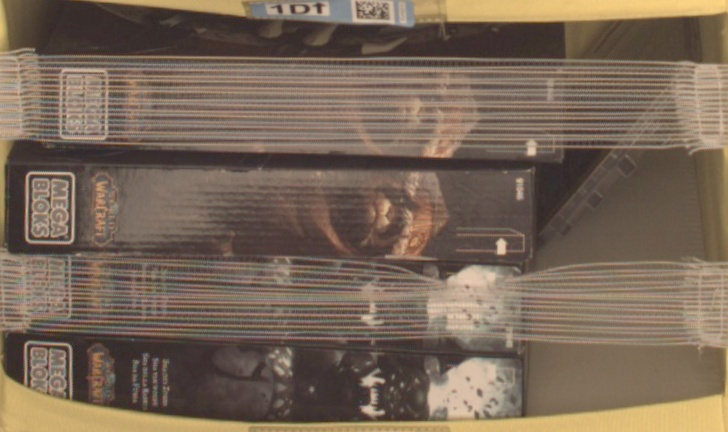

In [164]:
predict_image_label('test', 5)

### Cleanup
When we’re done with the endpoint, we can just delete it and the backing instances will be released. Run the following cell to delete the endpoint.

In [ ]:
predictor.delete_endpoint()